In [1]:
import numpy as np

from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import pandas as pd

import networkx as nx
# from causalgraphicalmodels import CausalGraphicalModel

import arviz as az
# ArviZ ships with style sheets!
# https://python.arviz.org/en/stable/examples/styles.html#example-styles
az.style.use("arviz-darkgrid")

import xarray as xr

import stan
import nest_asyncio

plt.style.use('default')
plt.rcParams['axes.facecolor'] = 'lightgray'

# To DAG's
import daft
from causalgraphicalmodels import CausalGraphicalModel

In [2]:
# Add fonts to matplotlib to run xkcd

from matplotlib import font_manager

font_dirs = ["fonts/"]  # The path to the custom font file.
font_files = font_manager.findSystemFonts(fontpaths=font_dirs)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

In [3]:
# To make plots like drawing 
# plt.xkcd()

In [4]:
# To running the stan in jupyter notebook
nest_asyncio.apply()

# Análise de Sobrevivência

Análise de sobrevivência, também denominada análise de sobrevida[1], é um ramo da estatística que estuda o tempo de duração esperado até a ocorrência de um ou mais eventos, tais como morte em organismos biológicos e falha em sistemas mecânicos.

A análise de sobrevivência procura responder perguntas como: 

- Qual é a proporção de uma população que sobreviverá depois de um certo tempo? 

- Daqueles que sobrevivem, a que ritmo eles vão morrer ou falhar? 

- Podem várias causas de morte ou falha ser levado em conta? 

- Como circunstâncias ou características específicas aumentam ou diminuem a probabilidade de sobrevivência?

#### Definições de termos comuns na análise de sobrevivência
Os seguintes termos são comumente usados em análises de sobrevivência:

- EVENTO - Morte, ocorrência de doença, recorrência da doença, recuperação ou outra experiência de interesse


- TEMPO - O tempo desde o início de um período de observação (como cirurgia ou início de tratamento) até (i) ocorrer um evento, ou (ii) finalizar o estudo, ou (iii) ocorrer a perda de contato ou retirada do estudo.


- CENSURA - Se um sujeito não experimenta um evento durante o tempo de observação ele será descrito como censurado. O sujeito é censurado no sentido em que nada é observado ou conhecido sobre ele após o tempo de censura. Um sujeito censurado pode ou não ter um evento após o final tempo de observação.


- FUNÇÃO DE SOBREVIVÊNCIA - É uma função, S, que associa a cada tempo t o número S (t) que é a probabilidade de que um sujeito sobreviva além do tempo t.

Ref: [Um modelo de sobrevivência em Stan - Eren M. Elçi](https://ermeel86.github.io/case_studies/surv_stan_example.html)

In [5]:
df = pd.read_csv('./data/mastectomy.csv', sep=",")
df['event'] = [ 1 if event_i == True else 0 for event_i in df['event'] ]
df.head(10)

,time,event,metastized
0,23,1,0
1,47,1,0
2,69,1,0
3,70,0,0
4,100,0,0
5,101,0,0
6,148,1,0
7,181,1,0
8,198,0,0
9,208,0,0


Mais precisamente, cada linha no conjunto de dados representa observações de uma mulher com diagnóstico de câncer de mama que foi submetida a mastectomia.

Legenda:

- A coluna `time` representa o tempo (em meses) pós-operatório em que a mulher foi observada.


- A coluna `event` indica se a mulher morreu ou não durante o período de observação.


- A coluna `metastized` representa se o câncer tinha metástase antes da cirurgia.

### Descritiva

In [6]:
df.groupby(by=['metastized', 'event']).describe()

time                                                    \
                 count        mean        std   min    25%    50%    75%   
metastized event                                                           
0          0       7.0  159.000000  65.475186  70.0  100.5  198.0  210.0   
           1       5.0   93.600000  67.748063  23.0   47.0   69.0  148.0   
1          0      11.0  151.090909  52.673436  76.0  108.0  145.0  200.0   
           1      21.0   48.000000  37.753146   5.0   24.0   40.0   61.0   

                         
                    max  
metastized event         
0          0      224.0  
           1      181.0  
1          0      225.0  
           1      143.0

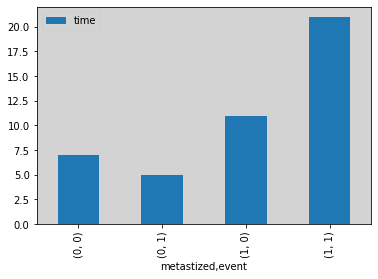

In [7]:
df.groupby(by=['metastized', 'event']).count().plot.bar()
plt.show()

### Modelo

Função de sobrevivência $S(t)$:

$$ S(t) = \mathbb{P} (T > t) = e^{-H(t)} $$


$T :=$ é o tempo de sobrevivência de um indivíduo.

$(T > t):=$ Tempo ($T$) que o paciente sobreviveu além do tempo $t$.

$H(t):=$ definido como perigo acumulado.



In [8]:
model = """
    data {
        int<lower=1> N_uncensored;  // Number of individuals not censured - event == 1
        int<lower=1> N_censored;  // Number of individuals censured - event == 0
        int<lower=0> NC;  // Number of covariates
        
        matrix[N_censored, NC] X_censored;
        matrix[N_uncensored, NC] X_uncensored;
        
        vector<lower=0>[N_censored] times_censored;  // time to censured event                         
        vector<lower=0>[N_uncensored] times_uncensored;  // // time to non-censured event
    }
    
    parameters {
        vector[NC] betas;
        real intercept;
    }
    
    model {
        // Prioris
        betas ~ normal(0,2);                                                            
        intercept ~ normal(-5,2);                                                     
        
        // Likelihood
        target += exponential_lpdf(times_uncensored | exp(intercept + X_uncensored * betas)); 
        target += exponential_lccdf(times_censored | exp(intercept + X_censored * betas));  
    }
"""

In [9]:
# Build the data dict to stan
covariates_name = ['metastized']  # From the inputs user


dat_list = {
    'N_uncensored': len(df[df['event'] == 1]),
    'N_censored': len(df[df['event'] == 0]),
    'NC': len(covariates_name),
    'X_censored': np.matrix(df.loc[df['event'] == 0, covariates_name]),
    'X_uncensored': np.matrix(df.loc[df['event'] == 1, covariates_name]),
    'times_censored': df.loc[df['event'] == 0, 'time'].values,
    'times_uncensored': df.loc[df['event'] == 1, 'time'].values
}

In [10]:
posteriori = stan.build(model, data=dat_list)
samples = posteriori.sample(num_chains=4, num_samples=1000)

Building: 0.1s


Building: 0.2s


Building: 0.4s


Building: 0.5s


Building: 0.6s


Building: 0.7s


Building: 0.8s


Building: 0.9s


Building: 1.0s


Building: 1.1s


Building: 1.2s


Building: 1.3s


Building: 1.4s


Building: 1.5s


Building: 1.6s


Building: 1.7s


Building: 1.8s


Building: 1.9s


Building: 2.0s


Building: 2.1s


Building: 2.2s


Building: 2.3s


Building: 2.4s


Building: 2.5s


Building: 2.6s


Building: 2.7s


Building: 2.8s


Building: 2.9s


Building: 3.0s


Building: 3.1s


Building: 3.2s


Building: 3.3s


Building: 3.4s


Building: 3.5s


Building: 3.6s


Building: 3.7s


Building: 3.8s


Building: 3.9s


Building: 4.0s


Building: 4.2s


Building: 4.3s


Building: 4.4s


Building: 4.5s


Building: 4.6s


Building: 4.7s


Building: 4.8s


Building: 4.9s


Building: 5.0s


Building: 5.1s


Building: 5.2s


Building: 5.3s


Building: 5.4s


Building: 5.5s


Building: 5.6s


Building: 5.7s


Building: 5.8s


Building: 5.9s


Building: 6.0s


Building: 6.1s


Building: 6.2s


Building: 6.3s


Building: 6.4s


Building: 6.5s


Building: 6.6s


Building: 6.7s


Building: 6.8s


Building: 6.9s


Building: 7.0s


Building: 7.1s


Building: 7.2s


Building: 7.3s


Building: 7.4s


Building: 7.5s


Building: 7.6s


Building: 7.7s


Building: 7.8s


Building: 8.0s


Building: 8.1s


Building: 8.2s


Building: 8.3s


Building: 8.4s


Building: 8.5s


Building: 8.6s


Building: 8.7s


Building: 8.8s


Building: 8.9s


Building: 9.0s


Building: 9.1s


Building: 9.2s


Building: 9.3s


Building: 9.4s


Building: 9.5s


Building: 9.6s


Building: 9.7s


Building: 9.8s


Building: 9.9s


Building: 10.0s


Building: 10.1s


Building: 10.2s


Building: 10.3s


Building: 10.4s


Building: 10.5s


Building: 10.6s


Building: 10.7s


Building: 10.8s


Building: 10.9s


Building: 11.0s


Building: 11.1s


Building: 11.2s


Building: 11.3s


Building: 11.5s


Building: 11.6s


Building: 11.7s


Building: 11.8s


Building: 11.9s


Building: 12.0s


Building: 12.1s


In file included from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun.hpp:124,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/multiply.hpp:7,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun/elt_multiply.hpp:9,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev/fun.hpp:55,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/rev.hpp:10,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math.hpp:19,
                 from /home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/model/model_header.hpp:4,
                 from /home/rodolpho/.cache/httpstan/4.10.1/m

Building: 12.2s


Building: 12.3s


Building: 12.4s


Building: 12.5s


Building: 12.6s


/home/rodolpho/.cache/httpstan/4.10.1/models/32el76we/model_32el76we.cpp: In instantiation of ‘void model_32el76we_namespace::model_32el76we::unconstrain_array_impl(const VecVar&, const VecI&, VecVar&, std::ostream*) const [with VecVar = std::vector<double, std::allocator<double> >; VecI = std::vector<int>; stan::require_vector_t<T_y>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/rodolpho/.cache/httpstan/4.10.1/models/32el76we/model_32el76we.cpp:527:36:   required from here
/home/rodolpho/.cache/httpstan/4.10.1/models/32el76we/model_32el76we.cpp:347:11: warning: variable ‘pos__’ set but not used [-Wunused-but-set-variable]
  347 |       int pos__ = std::numeric_limits<int>::min();
      |           ^~~~~
/home/rodolpho/.cache/httpstan/4.10.1/models/32el76we/model_32el76we.cpp: In instantiation of ‘void model_32el76we_namespace::model_32el76we::unconstrain_array_impl(const VecVar&, const VecI&, V

Building: 12.7s


Building: 12.8s


Building: 12.9s


/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp: In instantiation of ‘TupleT stan::math::internal::grad_2F1_impl_ab(const T1&, const T2&, const T3&, const T_z&, double, int) [with bool calc_a1 = true; bool calc_a2 = true; bool calc_b1 = true; T1 = stan::math::var_value<double>; T2 = stan::math::var_value<double>; T3 = stan::math::var_value<double>; T_z = stan::math::var_value<double>; ScalarT = stan::math::var_value<double>; TupleT = std::tuple<stan::math::var_value<double, void>, stan::math::var_value<double, void>, stan::math::var_value<double, void> >]’:
/home/rodolpho/Projects/bayesian/BAYES/lib/python3.8/site-packages/httpstan/include/stan/math/prim/fun/grad_2F1.hpp:205:78:   required from ‘TupleT stan::math::internal::grad_2F1_impl(const T1&, const T2&, const T3&, const T_z&, double, int) [with bool calc_a1 = true; bool calc_a2 = true; bool calc_b1 = true; bool calc_z = true; T1 = stan::math::var_value<double>; T

Building: 13.0s


Building: 13.1s


Building: 13.2s


Building: 13.3s


Building: 13.4s


Building: 13.5s


Building: 13.6s


Building: 13.7s


Building: 13.8s


Building: 13.9s


Building: 14.0s


Building: 14.1s


Building: 14.2s


Building: 14.3s


Building: 14.4s


Building: 14.5s


Building: 14.7s


Building: 14.8s


Building: 14.9s


Building: 15.0s


Building: 15.1s


Building: 15.2s


Building: 15.3s


Building: 15.4s


Building: 15.5s


Building: 15.6s


Building: 15.7s


Building: 15.8s


Building: 15.9s


Building: 16.0s


Building: 16.1s


Building: 16.2s


Building: 16.3s


Building: 16.4s


Building: 16.5s


Building: 16.6s


Building: 16.7s


Building: 16.8s


Building: 16.9s


Building: 17.0s


Building: 17.1s


Building: 17.2s


Building: 17.3s


/home/rodolpho/.cache/httpstan/4.10.1/models/32el76we/model_32el76we.cpp: In instantiation of ‘void model_32el76we_namespace::model_32el76we::write_array_impl(RNG&, VecR&, VecI&, VecVar&, bool, bool, std::ostream*) const [with RNG = boost::random::additive_combine_engine<boost::random::linear_congruential_engine<unsigned int, 40014, 0, 2147483563>, boost::random::linear_congruential_engine<unsigned int, 40692, 0, 2147483399> >; VecR = Eigen::Matrix<double, -1, 1>; VecI = std::vector<int>; VecVar = Eigen::Matrix<double, -1, 1>; stan::require_vector_like_vt<std::is_floating_point, VecR>* <anonymous> = 0; stan::require_vector_like_vt<std::is_integral, VecI>* <anonymous> = 0; stan::require_vector_vt<std::is_floating_point, VecVar>* <anonymous> = 0; std::ostream = std::basic_ostream<char>]’:
/home/rodolpho/.cache/httpstan/4.10.1/models/32el76we/model_32el76we.cpp:473:5:   required from ‘void model_32el76we_namespace::model_32el76we::write_array(RNG&, Eigen::Matrix<double, -1, 1>&, Eigen::Ma

Building: 17.4s


Building: 17.5s


Building: 17.6s


Building: 17.7s


Building: 17.9s


Building: 18.0s


Building: 18.1s


Building: 18.2s


Building: 18.3s


Building: 18.4s


Building: 18.5s


Building: 18.6s


Building: 18.7s


Building: 18.8s


Building: 18.9s


Building: 19.0s


Building: 19.1s


Building: 19.2s


Building: 19.3s


Building: 19.4s


Building: 19.5s


Building: 19.6s


Building: 19.7s


Building: 19.8s


Building: 19.9s


Building: 20.0s


Building: 20.1s


Building: 20.2s


Building: 20.3s


Building: 20.4s


Building: 20.5s


Building: 20.6s


Building: 20.7s


Building: 20.8s


Building: 20.9s


Building: 21.1s


Building: 21.2s


Building: 21.3s


Building: 21.4s


Building: 21.5s


Building: 21.6s


Building: 21.7s


Building: 21.8s


Building: 21.9s


Building: 22.0s


Building: 22.1s


Building: 22.2s


Building: 22.3s


Building: 22.4s


Building: 22.5s


Building: 22.6s


Building: 22.7s


Building: 22.8s


Building: 22.9s


Building: 23.0s


Building: 23.1s


Building: 23.2s


Building: 23.3s


Building: 23.4s


Building: 23.5s


Building: 23.6s


Building: 23.7s


Building: 23.8s


Building: 23.9s


Building: 24.0s


Building: 24.1s


Building: 24.2s


Building: 24.4s


Building: 24.5s


Building: 24.6s


Building: 24.7s


Building: 24.8s


Building: 24.9s


Building: 25.0s


Building: 25.1s


Building: 25.2s


Building: 25.3s


Building: 25.4s


Building: 25.5s


Building: 25.6s


Building: 25.7s


Building: 25.8s


Building: 25.9s


Building: 26.0s


Building: 26.1s


Building: 26.2s


Building: 26.3s


Building: 26.4s


Building: 26.5s


Building: 26.6s


Building: 26.7s


Building: 26.8s


Building: 26.9s


Building: 27.0s


Building: 27.1s


Building: 27.2s


Building: 27.3s


Building: 27.4s


Building: 27.5s


Building: 27.6s


Building: 27.7s


Building: 27.8s


Building: 27.9s


Building: 28.1s


Building: 28.2s


Building: 28.3s


Building: 28.4s


Building: 28.5s


Building: 28.6s


Building: 28.7s


Building: 28.8s


Building: 28.9s


Building: 29.0s


Building: 29.1s


Building: 29.2s


Building: 29.3s


Building: 29.4s


Building: 29.5s


Building: 29.6s


Building: 29.7s


Building: 29.8s


Building: 29.9s


AttributeError: 'NoneType' object has no attribute 'sample'

In [11]:
survival = az.from_pystan(
    posterior=samples,
    posterior_model=posteriori,
    observed_data=list(dat_list.keys())
)

In [12]:
az.summary(survival)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
betas[0],0.881,0.458,0.055,1.775,0.016,0.012,922.0,1124.0,1.01
intercept,-5.765,0.410,-6.534,-5.021,0.014,0.010,1000.0,962.0,1.01


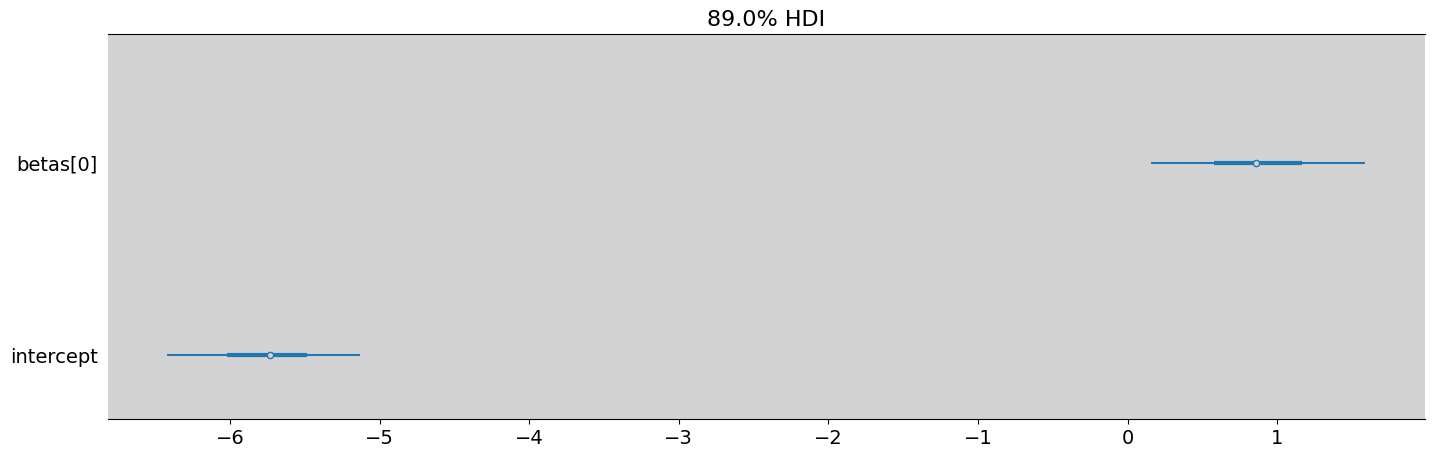

In [13]:
az.plot_forest(survival, var_names=['betas', 'intercept'], combined=True, figsize=(17, 5), hdi_prob=0.89)
plt.show()

In [30]:
import json

a = {
    'status': "done"
}

aaa = json.dumps(a)
json.loads(aaa)

{'status': 'done'}

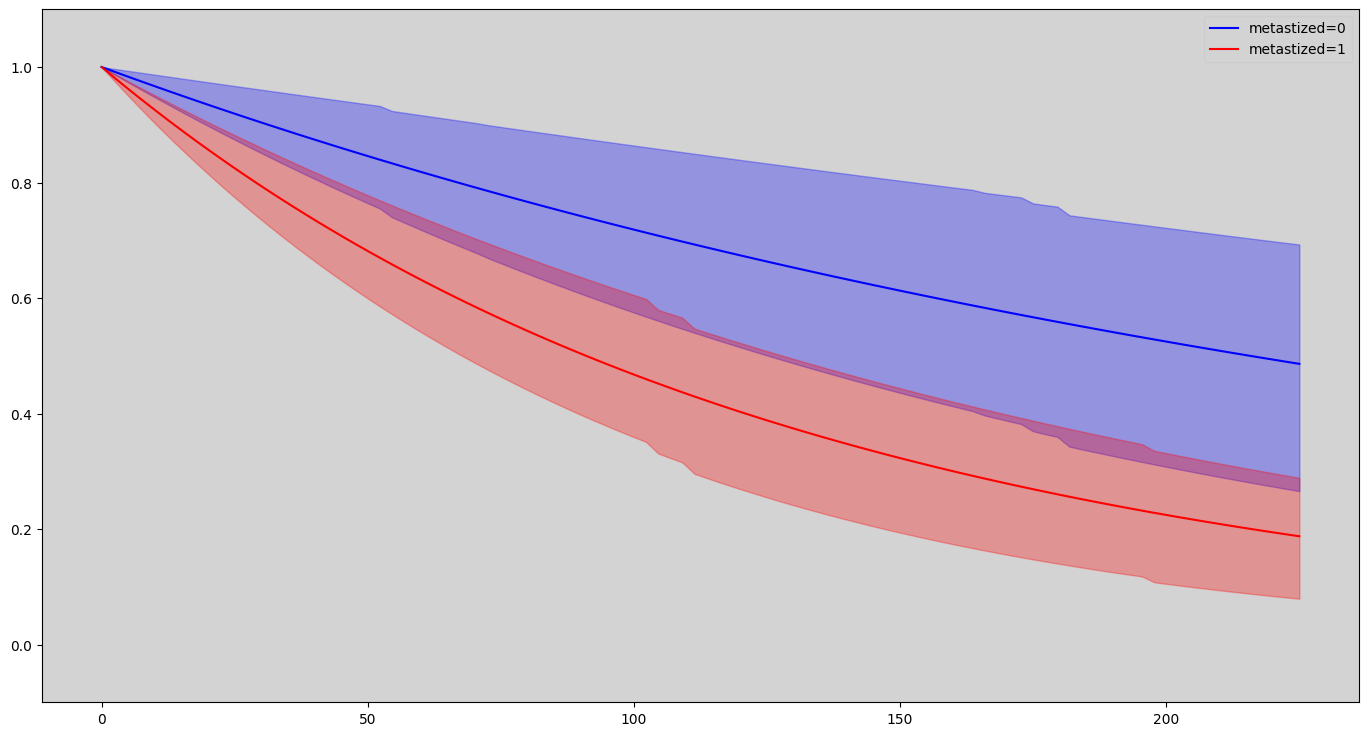

In [17]:
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.expon.html
# scale = 1 / lambda

x = np.linspace(0, max(df.time), 100)
intercpt = survival.posterior.intercept.values.flatten()
betas = survival.posterior.betas.values.flatten()

lam_x0 = 1.0 / np.exp(intercpt + betas*0)
lam_x1 = 1.0 / np.exp(intercpt + betas*1)

y_x0 = np.array([stats.expon.sf(x_i, scale=lam_x0) for x_i in x])
y_x1 = np.array([stats.expon.sf(x_i, scale=lam_x1) for x_i in x])

y_x0_hdi = np.array([az.hdi(y_x0[i], hdi_prob=0.89) for i in range(len(y_x0))])
y_x1_hdi = np.array([az.hdi(y_x1[i], hdi_prob=0.89) for i in range(len(y_x1))])

# Graph
# =====
plt.figure(figsize=(17, 9))

plt.plot(x, np.mean(y_x0, axis=1), color='blue', label='metastized=0')
plt.fill_between(x, y_x0_hdi[:, 1], y_x0_hdi[:, 0], color='blue', alpha=0.3)

plt.plot(x, np.mean(y_x1, axis=1), color='red', label='metastized=1')
plt.fill_between(x, y_x1_hdi[:, 1], y_x1_hdi[:, 0], color='red', alpha=0.3)

plt.ylim(-0.1, 1.1)
plt.legend()
plt.show()

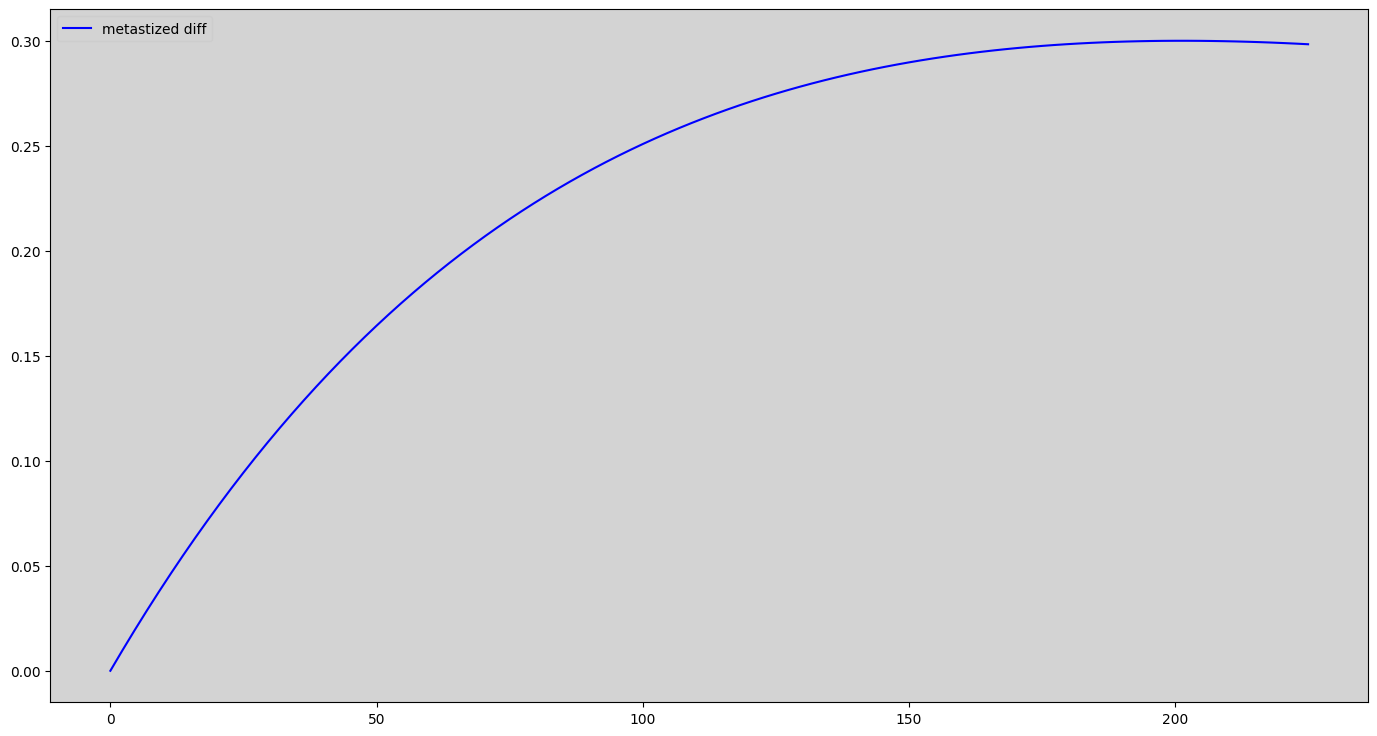

In [15]:
# Graph
# =====
plt.figure(figsize=(17, 9))

plt.plot(x, np.mean(y_x0 - y_x1, axis=1), color='blue', label='metastized diff')
plt.legend()
plt.show()